# Plot Idealized Channel Grid

This notebook demonstrates how to plot an idealized rectangular channel mesh from `chn_grd.dat` using xfvcom.
The grid uses Cartesian coordinates in meters without any geographic information.

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
from pathlib import Path

# Import xfvcom components
from xfvcom import FvcomInputLoader, FvcomPlotter, FvcomPlotConfig, FvcomPlotOptions
from xfvcom import make_node_marker_post

## Using FvcomInputLoader for Grid-Only Plotting

With the new `FvcomInputLoader`, we can load input files and create datasets compatible with `FvcomPlotter`. This allows us to use the same plotting tools for both input and output data.

In [2]:
# Path to the grid file
grid_file = Path("~/Github/FVCOM/Tests/GroundwaterDye/input/chn_grd.dat").expanduser()

# Load the grid using FvcomInputLoader
# For idealized grids, we use a dummy UTM zone (the generated lon/lat won't be meaningful)
loader = FvcomInputLoader(
    grid_path=grid_file, 
    utm_zone=54,
    add_dummy_time=True,
    add_dummy_siglay=True
)

# Display grid information
print(f"Grid loaded from: {loader.grid_path}")
print(f"Number of nodes: {loader.grid.node}")
print(f"Number of elements: {loader.grid.nele}")
print(f"X range: {loader.grid.x.min():.0f} to {loader.grid.x.max():.0f} meters")
print(f"Y range: {loader.grid.y.min():.0f} to {loader.grid.y.max():.0f} meters")
print(f"\nDataset dimensions: {dict(loader.ds.sizes)}")
print(f"Dataset variables: {list(loader.ds.data_vars)}")
print("\nNote: This is an idealized grid. We will use Cartesian coordinates (x,y).")

Grid loaded from: /home/teem/Github/FVCOM/Tests/GroundwaterDye/input/chn_grd.dat
Number of nodes: 871
Number of elements: 1620
X range: 0 to 800000 meters
Y range: 0 to 400000 meters

Dataset dimensions: {'node': 871, 'three': 3, 'nele': 1620, 'time': 1, 'siglay': 1, 'siglev': 2}
Dataset variables: ['x', 'y', 'lon', 'lat', 'nv', 'h', 'xc', 'yc', 'lonc', 'latc', 'Itime', 'Itime2', 'nv_zero', 'nv_ccw']

Note: This is an idealized grid. We will use Cartesian coordinates (x,y).


## Plot the mesh using FvcomPlotter

Now we can use the standard `FvcomPlotter` with our input dataset, just like we would with FVCOM output data.

Mesh and node plot saved as 'PNG/chn_mesh_nodes.png'


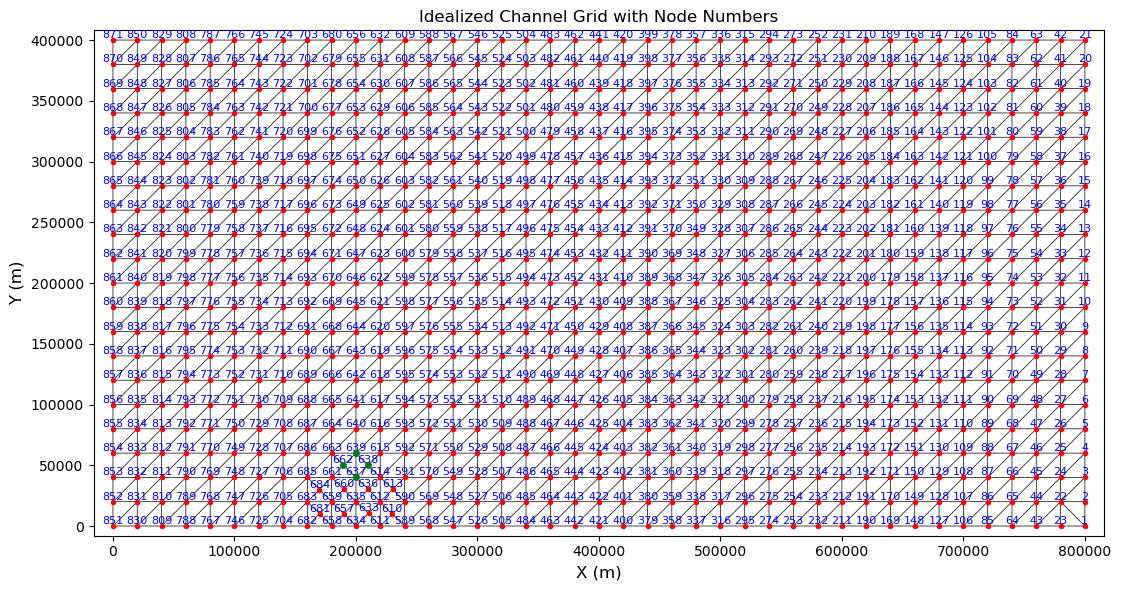

In [3]:
# Create plot configuration and plotter
config = FvcomPlotConfig()
plotter = FvcomPlotter(loader.ds, config)

# Create plot options for Cartesian mode
opts = FvcomPlotOptions(
    use_latlon=False,  # Use Cartesian coordinates for idealized grid
    with_mesh=True,    # Show the triangular mesh
    coastlines=False,  # No coastlines for idealized grid
    obclines=False,    # No open boundary lines
    mesh_linewidth=0.5,
    mesh_color='black',
    figsize=(12, 6)
)

# Create node marker post-processor to add node numbers
pp1 = make_node_marker_post(
    nodes=range(1, loader.ds.sizes["node"] + 1),   # 1-based indices when index_base=1
    plotter=plotter,
    marker_kwargs={
        'marker': 'o',
        'color': 'red',
        'markersize': 3
    },
    text_kwargs={
        'fontsize': 8,
        'color': 'blue',
        'ha': 'center',
        'va': 'bottom'
    },
    index_base=1,                          # 1-based numbering (FVCOM convention)
    use_latlon=False                       # Use Cartesian coordinates
)

# Create second marker set with 1-based indices
pp2 = make_node_marker_post(
    nodes=[637, 638, 639, 662],            # Now using 1-based indices!
    #nodes=[634],
    plotter=plotter,
    marker_kwargs={'marker': 'o', 'markersize': 4, 'color': 'green', 'zorder': 10},
    text_kwargs=None,  # No text labels
    index_base=1,                          # 1-based numbering
    use_latlon=False                       # Use Cartesian coordinates
)

# Plot the mesh with node markers and numbers
ax = plotter.plot_2d(da=None, opts=opts, post_process_func=pp1)

# Apply the second set of markers
pp2(ax)

# Add labels and title
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Idealized Channel Grid with Node Numbers')

# Expand the axis limits to prevent clipping of edge node numbers
x_range = loader.ds.x.max() - loader.ds.x.min()
y_range = loader.ds.y.max() - loader.ds.y.min()
x_margin = x_range * 0.02  # 2% margin
y_margin = y_range * 0.02  # 2% margin

ax.set_xlim(loader.ds.x.min() - x_margin, loader.ds.x.max() + x_margin)
ax.set_ylim(loader.ds.y.min() - y_margin, loader.ds.y.max() + y_margin)

# Add grid for better visualization
ax.grid(True, alpha=0)
plt.savefig('PNG/chn_mesh_nodes.png', dpi=300, bbox_inches='tight')
print("Mesh and node plot saved as 'PNG/chn_mesh_nodes.png'")
plt.tight_layout()
plt.show()

### Calculate element areas using the grid from loader
```Python
grid = loader.grid
```
### Get node coordinates for each element
```Python
x_elem = grid.x[grid.nv]  # Shape: (3, nele)
y_elem = grid.y[grid.nv]  # Shape: (3, nele)
```

### Calculate areas using cross product
`Area = 0.5 * |AB × AC|` where A, B, C are the three vertices
```Python
areas = 0.5 * np.abs(
    (x_elem[1] - x_elem[0]) * (y_elem[2] - y_elem[0]) - 
    (x_elem[2] - x_elem[0]) * (y_elem[1] - y_elem[0])
)

print(f"Element area statistics:")
print(f"  Min area: {areas.min():.2e} m²")
print(f"  Max area: {areas.max():.2e} m²")
print(f"  Mean area: {areas.mean():.2e} m²")
print(f"  Total area: {areas.sum():.2e} m²")
```

## Plot zoomed views using FvcomPlotter

We can use the `xlim` and `ylim` options to create zoomed views of the mesh.

Zoomed mesh and node plot saved as 'PNG/chn_mesh_nodes_zoomed.png'


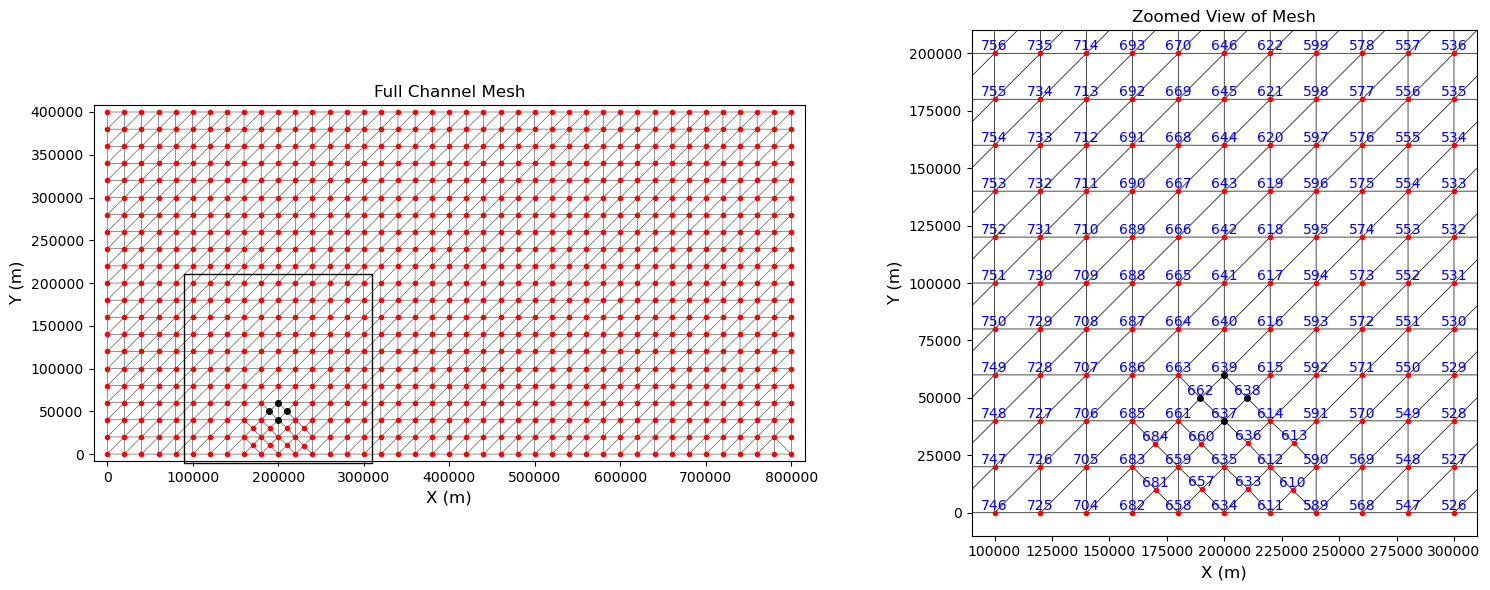

In [4]:
# Create two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Full mesh
opts_full = FvcomPlotOptions(
    use_latlon=False,
    with_mesh=True,
    coastlines=False,
    obclines=False,
    mesh_linewidth=0.3,
    mesh_color='black'
)

pp1 = make_node_marker_post(
    nodes=range(1, loader.ds.sizes["node"] + 1),   # 1-based indices when index_base=1
    plotter=plotter,
    marker_kwargs={'marker': 'o', 'color': 'red', 'markersize': 3},
    #text_kwargs={'fontsize': 10, 'color': 'blue', 'ha': 'center', 'va': 'bottom'},
    index_base=1,                          # 1-based numbering (FVCOM convention)
    use_latlon=False                       # Use Cartesian coordinates
)

# Create second marker set with 1-based indices
pp2 = make_node_marker_post(
    nodes=[637, 638, 639, 662],            # Now using 1-based indices!
    #nodes=[634],
    plotter=plotter,
    marker_kwargs={'marker': 'o', 'markersize': 4, 'color': 'black', 'zorder': 10},
    #text_kwargs={'fontsize': 12,'color': 'blue', 'ha': 'center', 'va': 'bottom'},
    text_kwargs=None,  # No text labels
    index_base=1,                          # 1-based numbering
    use_latlon=False                       # Use Cartesian coordinates
)

plotter.plot_2d(da=None, ax=ax1, opts=opts_full, post_process_func=pp1)
pp2(ax1)

# Expand the axis limits to prevent clipping of edge node numbers
x_range = loader.ds.x.max() - loader.ds.x.min()
y_range = loader.ds.y.max() - loader.ds.y.min()
x_margin = x_range * 0.02  # 2% margin
y_margin = y_range * 0.02  # 2% margin

ax1.set_xlim(loader.ds.x.min() - x_margin, loader.ds.x.max() + x_margin)
ax1.set_ylim(loader.ds.y.min() - y_margin, loader.ds.y.max() + y_margin)

ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_title('Full Channel Mesh')
ax1.grid(True, alpha=0)

# Zoomed view
offset=10000
zoom_x = [100000-offset, 300000+offset]  # 200 km section
zoom_y = [0-offset, 200000+offset]  # 200 km section

opts_zoom = FvcomPlotOptions(
    use_latlon=False,
    with_mesh=True,
    coastlines=False,
    obclines=False,
    mesh_linewidth=0.5,
    mesh_color='black',
    xlim=zoom_x,
    ylim=zoom_y
)

# Create node marker post-processor to add node numbers
pp1 = make_node_marker_post(
    nodes=range(1, loader.ds.sizes["node"] + 1),   # 1-based indices when index_base=1
    plotter=plotter,
    marker_kwargs={
        'marker': 'o',
        'color': 'red',
        'markersize': 3
    },
    text_kwargs={
        'fontsize': 10,
        'color': 'blue',
        'ha': 'center',
        'va': 'bottom'
    },
    index_base=1,                          # 1-based numbering (FVCOM convention)
    use_latlon=False                       # Use Cartesian coordinates
)

# Create second marker set with 1-based indices
pp2 = make_node_marker_post(
    nodes=[637, 638, 639, 662],            # Now using 1-based indices!
    #nodes=[634],
    plotter=plotter,
    marker_kwargs={'marker': 'o', 'markersize': 4, 'color': 'black', 'zorder': 10},
    #text_kwargs={'fontsize': 12,'color': 'blue', 'ha': 'center', 'va': 'bottom'},
    text_kwargs=None,  # No text labels
    index_base=1,                          # 1-based numbering
    use_latlon=False                       # Use Cartesian coordinates
)

plotter.plot_2d(da=None, ax=ax2, opts=opts_zoom, post_process_func=pp1)
pp2(ax2)

ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_title('Zoomed View of Mesh')
ax2.grid(True, alpha=0)

# Add rectangle on full mesh to show zoom area
from matplotlib.patches import Rectangle
rect = Rectangle((zoom_x[0], zoom_y[0]), 
                 zoom_x[1] - zoom_x[0], 
                 zoom_y[1] - zoom_y[0],
                 fill=False, edgecolor='black', linewidth=1, zorder=10, clip_on=False)
ax1.add_patch(rect)
plt.savefig('PNG/chn_mesh_nodes_zoomed.png', dpi=300, bbox_inches='tight')
print("Zoomed mesh and node plot saved as 'PNG/chn_mesh_nodes_zoomed.png'")
plt.tight_layout()
plt.show()